In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.25,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_025_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 15:20 - loss: 0.1148 - STD: 1.2556e-04 - MAE: 0.3260

 11/793 [..............................] - ETA: 4s - loss: 0.0316 - STD: 2.1094e-04 - MAE: 0.1409   

 20/793 [..............................] - ETA: 4s - loss: 0.0250 - STD: 1.4463e-04 - MAE: 0.1213

 29/793 [>.............................] - ETA: 4s - loss: 0.0207 - STD: 1.2735e-04 - MAE: 0.1112

 37/793 [>.............................] - ETA: 4s - loss: 0.0183 - STD: 1.1602e-04 - MAE: 0.1033

 45/793 [>.............................] - ETA: 4s - loss: 0.0168 - STD: 1.1103e-04 - MAE: 0.0982

 54/793 [=>............................] - ETA: 4s - loss: 0.0156 - STD: 1.1134e-04 - MAE: 0.0951

 63/793 [=>............................] - ETA: 4s - loss: 0.0147 - STD: 1.1452e-04 - MAE: 0.0919

 72/793 [=>............................] - ETA: 4s - loss: 0.0140 - STD: 1.2156e-04 - MAE: 0.0901

 81/793 [==>...........................] - ETA: 4s - loss: 0.0135 - STD: 1.3201e-04 - MAE: 0.0886

 88/793 [==>...........................] - ETA: 4s - loss: 0.0132 - STD: 1.4283e-04 - MAE: 0.0876

 97/793 [==>...........................] - ETA: 4s - loss: 0.0128 - STD: 1.6057e-04 - MAE: 0.0865

106/793 [===>..........................] - ETA: 4s - loss: 0.0125 - STD: 1.8357e-04 - MAE: 0.0855

115/793 [===>..........................] - ETA: 4s - loss: 0.0122 - STD: 2.1331e-04 - MAE: 0.0846

124/793 [===>..........................] - ETA: 4s - loss: 0.0120 - STD: 2.5315e-04 - MAE: 0.0839

132/793 [===>..........................] - ETA: 4s - loss: 0.0118 - STD: 3.0049e-04 - MAE: 0.0834

141/793 [====>.........................] - ETA: 4s - loss: 0.0116 - STD: 3.7448e-04 - MAE: 0.0828

150/793 [====>.........................] - ETA: 3s - loss: 0.0115 - STD: 4.8036e-04 - MAE: 0.0824

159/793 [=====>........................] - ETA: 3s - loss: 0.0114 - STD: 6.3970e-04 - MAE: 0.0820

167/793 [=====>........................] - ETA: 3s - loss: 0.0112 - STD: 8.5378e-04 - MAE: 0.0815

174/793 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.0011 - MAE: 0.0812    

183/793 [=====>........................] - ETA: 3s - loss: 0.0110 - STD: 0.0016 - MAE: 0.0807

192/793 [======>.......................] - ETA: 3s - loss: 0.0108 - STD: 0.0024 - MAE: 0.0803

201/793 [======>.......................] - ETA: 3s - loss: 0.0107 - STD: 0.0034 - MAE: 0.0798

210/793 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0046 - MAE: 0.0793

217/793 [=======>......................] - ETA: 3s - loss: 0.0105 - STD: 0.0056 - MAE: 0.0789

226/793 [=======>......................] - ETA: 3s - loss: 0.0103 - STD: 0.0069 - MAE: 0.0784

235/793 [=======>......................] - ETA: 3s - loss: 0.0102 - STD: 0.0082 - MAE: 0.0779

244/793 [========>.....................] - ETA: 3s - loss: 0.0101 - STD: 0.0094 - MAE: 0.0774

253/793 [========>.....................] - ETA: 3s - loss: 0.0100 - STD: 0.0105 - MAE: 0.0770

261/793 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 0.0115 - MAE: 0.0767

270/793 [=========>....................] - ETA: 3s - loss: 0.0098 - STD: 0.0126 - MAE: 0.0762

279/793 [=========>....................] - ETA: 3s - loss: 0.0097 - STD: 0.0135 - MAE: 0.0758

288/793 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 0.0145 - MAE: 0.0753

297/793 [==========>...................] - ETA: 3s - loss: 0.0095 - STD: 0.0156 - MAE: 0.0748

305/793 [==========>...................] - ETA: 3s - loss: 0.0094 - STD: 0.0166 - MAE: 0.0744

313/793 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 0.0175 - MAE: 0.0740

322/793 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.0185 - MAE: 0.0736

331/793 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.0195 - MAE: 0.0731

340/793 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0205 - MAE: 0.0727

347/793 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0213 - MAE: 0.0724

356/793 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.0222 - MAE: 0.0720

365/793 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.0231 - MAE: 0.0716

374/793 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0239 - MAE: 0.0712

383/793 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0247 - MAE: 0.0708

391/793 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0255 - MAE: 0.0705

400/793 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0264 - MAE: 0.0701

409/793 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0272 - MAE: 0.0697

418/793 [==============>...............] - ETA: 2s - loss: 0.0083 - STD: 0.0279 - MAE: 0.0694

427/793 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0286 - MAE: 0.0690

435/793 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0293 - MAE: 0.0688

444/793 [===============>..............] - ETA: 2s - loss: 0.0081 - STD: 0.0299 - MAE: 0.0684

453/793 [================>.............] - ETA: 2s - loss: 0.0080 - STD: 0.0306 - MAE: 0.0681

462/793 [================>.............] - ETA: 2s - loss: 0.0080 - STD: 0.0313 - MAE: 0.0678

471/793 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0319 - MAE: 0.0675

479/793 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0324 - MAE: 0.0672

486/793 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0329 - MAE: 0.0670

494/793 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0334 - MAE: 0.0668

503/793 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0340 - MAE: 0.0665

512/793 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0345 - MAE: 0.0662

521/793 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0351 - MAE: 0.0659

530/793 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0356 - MAE: 0.0657

538/793 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0361 - MAE: 0.0654

547/793 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0366 - MAE: 0.0652

556/793 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0371 - MAE: 0.0649

563/793 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0375 - MAE: 0.0647

573/793 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0380 - MAE: 0.0644

582/793 [=====================>........] - ETA: 1s - loss: 0.0072 - STD: 0.0385 - MAE: 0.0642

591/793 [=====================>........] - ETA: 1s - loss: 0.0072 - STD: 0.0390 - MAE: 0.0639

600/793 [=====================>........] - ETA: 1s - loss: 0.0071 - STD: 0.0394 - MAE: 0.0637

609/793 [======================>.......] - ETA: 1s - loss: 0.0071 - STD: 0.0399 - MAE: 0.0635

616/793 [======================>.......] - ETA: 1s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0633

625/793 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0405 - MAE: 0.0632

634/793 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0408 - MAE: 0.0630

643/793 [=======================>......] - ETA: 1s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0628

652/793 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0416 - MAE: 0.0626

660/793 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0419 - MAE: 0.0625

668/793 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0623

677/793 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0425 - MAE: 0.0622

685/793 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0428 - MAE: 0.0620

693/793 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0618

702/793 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0435 - MAE: 0.0616

710/793 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0438 - MAE: 0.0615

719/793 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0441 - MAE: 0.0613

728/793 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0444 - MAE: 0.0611

737/793 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0447 - MAE: 0.0610

746/793 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0450 - MAE: 0.0608

754/793 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0453 - MAE: 0.0607

763/793 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0456 - MAE: 0.0605

772/793 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0459 - MAE: 0.0603

781/793 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0462 - MAE: 0.0602

790/793 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0465 - MAE: 0.0600

793/793 [==============================] - 7s 8ms/step - loss: 0.0064 - STD: 0.0465 - MAE: 0.0600 - val_loss: 0.0035 - val_STD: 0.0542 - val_MAE: 0.0432


Epoch 2/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0467

  8/793 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461 

 16/793 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0464

 25/793 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0461

 34/793 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

 43/793 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

 51/793 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

 59/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

 68/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

 77/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

 86/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0463

 95/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0463

103/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

112/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

121/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

130/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

139/793 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0462

147/793 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0462

155/793 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

164/793 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

173/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0462

181/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0462

190/793 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

198/793 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

207/793 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

216/793 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

225/793 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

233/793 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

241/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

250/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

259/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

268/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

277/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

285/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

294/793 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

302/793 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

311/793 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

320/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

328/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

336/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

345/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

353/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

361/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

368/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0456

377/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0456

386/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

395/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

404/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

411/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

420/793 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

429/793 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

438/793 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

447/793 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

455/793 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

464/793 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

473/793 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

481/793 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

490/793 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

499/793 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

508/793 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

517/793 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

525/793 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

534/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

543/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

552/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

561/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

569/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

578/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

587/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

596/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

604/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

612/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

620/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

629/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

637/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

646/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

655/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

663/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

672/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

681/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

690/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

699/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

707/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

716/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

725/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

733/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

741/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

750/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

758/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

767/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

776/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

785/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0449

793/793 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0449 - val_loss: 0.0033 - val_STD: 0.0560 - val_MAE: 0.0409


Epoch 3/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0437

  9/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0446 

 18/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

 27/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0438

 36/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0435

 44/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

 52/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

 59/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0436

 67/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

 76/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0436

 85/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

 93/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

101/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

106/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

111/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

116/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

123/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

132/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

141/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

150/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

159/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

168/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

176/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

184/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

191/793 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

200/793 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

209/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

218/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

227/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

235/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

244/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

253/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

262/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

270/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

276/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

284/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

293/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

302/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

310/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

317/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

322/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

327/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

333/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

341/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

350/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

359/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

368/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

376/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

383/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

391/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

399/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

405/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

414/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

423/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

432/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

440/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

447/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

452/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

457/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

463/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

471/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

480/793 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

489/793 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

497/793 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

505/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

514/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

523/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

530/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

539/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

548/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

557/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

566/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

575/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

581/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

590/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

599/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

608/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

616/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

623/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

629/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

634/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

640/793 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

648/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

657/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

666/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

675/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

683/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

692/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

701/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

708/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

715/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

724/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

733/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

742/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

750/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

755/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

760/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

765/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

772/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

780/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

789/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

793/793 [==============================] - 6s 7ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431 - val_loss: 0.0032 - val_STD: 0.0556 - val_MAE: 0.0402


Epoch 4/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0437

 10/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416 

 19/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

 27/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 35/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0419

 43/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

 52/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

 61/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 67/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 75/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

 83/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

 92/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

100/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

108/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

113/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

118/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

123/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

130/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

138/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

146/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

155/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

164/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

173/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

182/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

191/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

198/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

206/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

214/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

222/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

230/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

238/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

246/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

253/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

261/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

269/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

278/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

287/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

296/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

305/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

313/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

321/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

330/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

339/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

348/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

356/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

365/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

374/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

383/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

392/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

401/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

410/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

419/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

426/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

434/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

443/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

452/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

461/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

470/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

479/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

488/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

497/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

506/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

515/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

524/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

532/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

538/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

546/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

555/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

560/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

568/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

577/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

586/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

594/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

603/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

612/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

620/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

628/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

635/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

643/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

651/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

659/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

666/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

673/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

681/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

689/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

696/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

704/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

711/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

719/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

726/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

734/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

741/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

748/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

755/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

763/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

771/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

779/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

787/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

793/793 [==============================] - 6s 7ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420 - val_loss: 0.0028 - val_STD: 0.0615 - val_MAE: 0.0385


Epoch 5/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0416

  8/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416 

 16/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

 23/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

 30/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

 37/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

 44/793 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

 52/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

 59/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 67/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 74/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 82/793 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

 89/793 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 95/793 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

101/793 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

107/793 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

113/793 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

119/793 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

125/793 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

130/793 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

135/793 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

140/793 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

147/793 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

155/793 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

163/793 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

171/793 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

178/793 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

185/793 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

193/793 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

200/793 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

206/793 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

211/793 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

219/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

226/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

234/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

241/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

248/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

256/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

264/793 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

272/793 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

280/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

288/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

296/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

304/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

313/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

321/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

330/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

338/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

345/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

353/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

362/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

371/793 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

380/793 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

388/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

397/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

406/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

414/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

422/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

430/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

438/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

446/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

455/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

463/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

472/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

481/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

489/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

498/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

507/793 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

516/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

525/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

534/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

543/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

552/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

561/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

570/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

579/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

588/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

596/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

604/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

613/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

622/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

631/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

640/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

648/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

657/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

666/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

675/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

684/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

692/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

701/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

710/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

719/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

728/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

737/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

745/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

754/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

763/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

772/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

781/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

789/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

793/793 [==============================] - 6s 7ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0597 - val_MAE: 0.0381


Epoch 6/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0412

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0412 

 18/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

 27/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

 35/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 43/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

 52/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 61/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 70/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 79/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 88/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 96/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

104/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

113/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

122/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

131/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

139/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

147/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

154/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

162/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

171/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

180/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

189/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

197/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

206/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

215/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

224/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

232/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

240/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

249/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

258/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

267/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

276/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

285/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

293/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

302/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

311/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

320/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

329/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

337/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

345/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

354/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

363/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

372/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

381/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

389/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

398/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

407/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

416/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

424/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

432/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

441/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

450/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

459/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

468/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

476/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

485/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

494/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

503/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

512/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

520/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

529/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

538/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

547/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

556/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

565/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

574/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

582/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

591/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

600/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

609/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

618/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

626/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

635/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

644/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

653/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

661/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

669/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

678/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

686/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

694/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

703/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

711/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

720/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

729/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

738/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

747/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

755/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

764/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

773/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

782/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

791/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405 - val_loss: 0.0032 - val_STD: 0.0588 - val_MAE: 0.0400


Epoch 7/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0412

 10/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412 

 19/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

 28/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

 37/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0403

 46/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 54/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 63/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

 72/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

 81/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 89/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 97/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

106/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

114/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

123/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

132/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0402

140/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0401

148/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

157/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

166/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

175/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

183/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

192/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

201/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

210/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

219/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

227/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

236/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

245/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

254/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

263/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

272/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

280/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

289/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

297/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

306/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

315/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

323/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

332/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

341/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

350/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

359/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

367/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

376/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

385/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

394/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

403/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

412/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

420/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

428/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

437/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

446/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

455/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

464/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

472/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

481/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

490/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

499/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

508/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

517/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

525/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

534/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

543/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

552/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

561/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

569/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

578/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

587/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

596/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

605/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

613/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

622/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

631/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

640/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

648/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

656/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

665/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

674/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

683/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

692/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

701/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

709/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

718/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

727/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

736/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

745/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

762/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

771/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

780/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

789/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0636 - val_MAE: 0.0381


Epoch 8/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0382

  8/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0400 

 17/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 26/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0393

 35/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0392

 43/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0393

 51/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

 59/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

 68/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

 77/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

 86/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

 94/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

102/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

111/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

120/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

129/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

138/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

146/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

155/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

164/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

173/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

182/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

189/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

198/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

207/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

216/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

225/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

233/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

241/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

250/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

259/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

268/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

277/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

285/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

294/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

303/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

312/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

321/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

329/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

338/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

347/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

356/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

365/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

373/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

382/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

391/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

400/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

409/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

417/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

426/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

435/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

444/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

453/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

461/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

470/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

479/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

488/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

497/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

505/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

522/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

531/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

540/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

549/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

557/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

574/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

601/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

609/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

618/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

627/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

636/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

645/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

653/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

662/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

671/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

680/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

689/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

697/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

705/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

714/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

723/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

732/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

741/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

749/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

767/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

776/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

785/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

793/793 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393 - val_loss: 0.0028 - val_STD: 0.0612 - val_MAE: 0.0380


Epoch 9/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0387 

 19/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0390

 28/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 37/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

 44/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 53/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 62/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 71/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 80/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

 88/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

 97/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

106/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

114/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

123/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

131/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

140/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

149/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

158/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

167/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

175/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

184/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

193/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

202/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

210/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

218/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

227/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

236/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

245/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

253/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

261/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

270/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

279/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

288/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

297/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

305/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

314/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

323/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

332/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

339/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

347/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

356/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

365/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

374/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

382/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

391/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

400/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

409/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

418/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

426/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

434/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

443/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

451/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

459/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

468/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

477/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

486/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

495/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

503/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

512/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

521/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

530/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

539/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

547/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

556/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

565/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

574/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

583/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

591/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

600/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

609/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

618/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

627/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

635/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

644/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

653/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

662/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

671/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

679/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

687/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

696/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

704/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

713/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

722/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

729/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

738/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

747/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

756/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

765/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

773/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

781/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

790/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0622 - val_MAE: 0.0373


Epoch 10/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0383

  9/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373 

 17/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0376

 26/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

 35/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

 44/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

 53/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 61/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

 70/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

 79/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

 88/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

 97/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

105/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

114/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

123/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

132/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

141/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

150/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

158/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

167/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

176/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

185/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

194/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

201/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

209/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

218/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

227/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

236/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

245/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

253/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

262/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

271/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

280/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

289/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

297/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

305/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

314/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

323/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

332/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

340/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

348/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

357/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

365/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

374/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

383/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

391/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

400/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

409/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

418/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

427/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

435/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

443/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

452/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

461/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

469/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

478/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

487/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

496/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

504/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

513/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

521/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

528/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

535/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

540/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

549/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

558/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

567/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

575/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

582/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

587/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

592/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

597/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

604/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

613/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

622/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

631/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

640/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

649/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

658/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

666/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

681/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

690/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

699/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

708/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

717/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

726/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

735/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

744/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

753/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

762/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

771/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

780/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

789/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383 - val_loss: 0.0027 - val_STD: 0.0649 - val_MAE: 0.0379


Epoch 11/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0026 - STD: 0.0788 - MAE: 0.0382

  9/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383 

 18/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0816 - MAE: 0.0382

 26/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0382

 33/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0381

 38/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0381

 43/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0382

 49/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0382

 57/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0381

 66/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0379

 74/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0379

 82/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0378

 91/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0379

 99/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

108/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

116/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

123/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

130/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

137/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

145/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

154/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

162/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

170/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

176/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

181/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

186/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

193/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

201/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

210/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

219/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

228/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

237/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

245/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

253/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

260/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

267/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

275/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

284/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

293/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

301/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

310/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

318/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

327/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

336/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

345/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

354/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

363/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

372/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

381/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

389/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

398/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

407/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

415/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

421/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

429/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

438/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

447/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

455/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

462/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

467/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

472/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

478/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

486/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

495/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

503/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

511/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

519/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

527/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

535/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

543/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

550/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

557/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

563/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

572/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

580/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

589/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

597/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

604/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

609/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

614/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

621/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

629/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

638/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

647/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

655/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

663/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

680/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

686/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

693/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

702/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

711/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

720/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

729/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

737/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

746/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

754/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

763/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

772/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

781/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

789/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

793/793 [==============================] - 6s 7ms/step - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378 - val_loss: 0.0027 - val_STD: 0.0687 - val_MAE: 0.0378


Epoch 12/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.0853 - MAE: 0.0375

  9/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0381 

 18/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

 26/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

 34/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0380

 40/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

 45/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

 50/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

 57/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0377

 65/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0376

 74/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

 83/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

 91/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

 99/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

108/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

117/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0375

124/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0375

132/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

139/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

146/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

154/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0374

162/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

170/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

178/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

186/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

194/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

203/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0374

212/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

221/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

230/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

239/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

247/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

256/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

265/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0374

274/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0374

283/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

292/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0375

301/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

311/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

320/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

329/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

338/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

347/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

356/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

365/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

374/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

383/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

392/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

401/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

410/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

419/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

428/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

437/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

446/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

455/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

462/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

469/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

478/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

487/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

495/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

503/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

512/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

521/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

529/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

537/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

546/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

555/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

563/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

571/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

579/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

587/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

594/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

602/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

609/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

617/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

625/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

633/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

640/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

648/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

656/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

664/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

672/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

680/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

688/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

696/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

704/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

712/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

720/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

728/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

736/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

751/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

759/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

767/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

775/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

783/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

791/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

793/793 [==============================] - 5s 7ms/step - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375 - val_loss: 0.0030 - val_STD: 0.0595 - val_MAE: 0.0385


Epoch 13/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0373

  8/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0380 

 16/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0384

 24/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

 32/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

 40/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

 48/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

 56/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

 64/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

 71/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

 77/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

 83/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

 89/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

 95/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

101/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

107/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

115/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

122/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

130/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

138/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

146/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

153/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

161/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

168/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

175/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

181/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

189/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

196/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

204/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

211/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

218/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

226/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

235/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

243/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

251/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

259/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

267/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

275/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

283/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

291/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

299/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

307/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

315/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

323/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

332/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

341/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

349/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

358/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

367/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

376/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

384/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

393/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

401/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

409/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

417/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

426/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

434/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

443/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

452/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

460/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

468/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

477/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

486/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

495/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

504/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

513/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

522/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

531/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

540/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

549/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

557/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

565/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

574/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

583/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

592/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

600/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

609/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

618/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

627/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

636/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

644/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

653/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

662/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

671/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

680/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

689/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

698/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

707/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

716/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

725/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

734/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

742/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

751/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

760/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

769/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

785/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

793/793 [==============================] - 6s 7ms/step - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371 - val_loss: 0.0027 - val_STD: 0.0658 - val_MAE: 0.0381


Epoch 14/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.0826 - MAE: 0.0371

 10/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0823 - MAE: 0.0372 

 19/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

 27/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

 44/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

 53/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

 62/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

 71/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

 79/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

 88/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

 97/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

105/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

113/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

122/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

131/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

140/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

148/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

156/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

164/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

173/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

182/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

190/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

198/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

207/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

216/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

225/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

234/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

242/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

251/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

260/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

269/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

278/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

286/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

295/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

304/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

313/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

322/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

329/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

338/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

347/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

356/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

365/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

373/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

382/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

391/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

400/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

409/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

417/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

426/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

435/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

444/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

452/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

460/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

469/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

478/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

487/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

495/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

504/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

513/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

522/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

531/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

539/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

548/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

557/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

566/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

575/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

584/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

592/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

600/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

609/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

618/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

627/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

635/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

644/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

653/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

662/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

671/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

679/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

688/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

697/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

706/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

714/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

722/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

731/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

740/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

749/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

758/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

766/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

775/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

784/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

793/793 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366 - val_loss: 0.0027 - val_STD: 0.0634 - val_MAE: 0.0379


Epoch 15/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0023 - STD: 0.0776 - MAE: 0.0363

  9/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369 

 18/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0366

 27/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 36/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0370

 45/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

 53/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

 62/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

 71/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0370

 80/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0371

 89/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0372

 97/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

106/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

114/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0370

123/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0370

132/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0369

140/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

149/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

158/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368

167/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0368

176/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

184/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

193/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

202/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

211/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

220/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

228/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

237/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

246/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

255/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

263/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

271/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

279/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

288/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

297/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

306/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

314/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

323/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

332/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

341/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

349/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

357/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

366/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

375/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

384/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

393/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

400/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

408/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

417/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

426/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

435/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

443/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

451/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

460/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

469/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

478/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

486/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

495/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

504/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

513/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

522/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

530/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

539/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

547/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

556/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

565/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

573/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

582/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

591/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

600/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

609/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

617/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

625/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

634/793 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

643/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

652/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

661/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

669/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

678/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

687/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

696/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

705/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

713/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

722/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

731/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

740/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

749/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

757/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

766/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

775/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

784/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

792/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

793/793 [==============================] - 5s 6ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364 - val_loss: 0.0028 - val_STD: 0.0628 - val_MAE: 0.0373


Epoch 16/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0789 - MAE: 0.0360

 10/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0357

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0357

 35/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

 43/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0358

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

 61/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

 70/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

 79/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

 87/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

 96/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

105/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

114/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

123/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

131/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

140/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

149/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

158/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

167/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

176/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

185/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

194/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

203/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

212/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

221/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

229/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

238/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

247/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

256/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

265/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

273/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

282/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

291/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

300/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

309/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

317/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

326/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

335/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

343/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

352/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

360/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

369/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

378/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

387/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

396/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

404/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

413/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

422/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

430/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

439/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

448/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

456/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

465/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

474/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

482/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

489/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

497/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

506/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

515/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

524/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

533/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

541/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

550/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

559/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

568/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

577/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

586/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

595/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

604/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

613/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

622/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

630/793 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

639/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

648/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

657/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

666/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

674/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

683/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

691/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

699/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

708/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

716/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

725/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

734/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

743/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

752/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

761/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

770/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

779/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

788/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

793/793 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360 - val_loss: 0.0027 - val_STD: 0.0661 - val_MAE: 0.0369


Epoch 17/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0346

 10/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0803 - MAE: 0.0354 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0356

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0359

 36/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

 44/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0361

 53/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

 62/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0361

 71/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0361

 79/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0360

 88/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0359

 97/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0359

106/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

115/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0359

123/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

132/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

141/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0359

150/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

159/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0358

167/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0358

176/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

185/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

194/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

203/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0358

212/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

221/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0358

230/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0358

238/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

246/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

255/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

264/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

272/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

280/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

289/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

298/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

307/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

315/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0357

323/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

332/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

341/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

349/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

358/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

366/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

374/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

382/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

391/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

400/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

408/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

416/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

425/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

434/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

443/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

452/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

460/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

469/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

478/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

487/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

496/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

504/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

513/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

522/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

531/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

540/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

548/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

557/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

566/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

575/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

584/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

592/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

601/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

610/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

619/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

627/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

635/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

644/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

653/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

662/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

671/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

679/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

688/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

697/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

706/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

714/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

722/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

731/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

740/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

748/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

756/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

764/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

773/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

782/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

791/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

793/793 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356 - val_loss: 0.0027 - val_STD: 0.0703 - val_MAE: 0.0382


Epoch 18/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0024 - STD: 0.0845 - MAE: 0.0365

  8/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352 

 17/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0815 - MAE: 0.0354

 26/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

 35/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

 44/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

 61/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

 70/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0357

 79/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0355

 88/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

 95/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

104/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

113/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0355

122/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

130/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

138/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

147/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

155/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

164/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

173/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

181/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

190/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

199/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

208/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

217/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

226/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

235/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

243/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

251/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

259/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

267/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

275/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

281/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

290/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

299/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

308/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

316/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

323/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

328/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

333/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

338/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

346/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

355/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

364/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

373/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

380/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

388/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

397/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

404/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

411/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

420/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

429/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

437/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

446/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

455/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

463/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

472/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

481/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

490/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

499/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

508/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

516/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

525/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

534/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

544/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

553/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

562/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

568/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

576/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

585/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

594/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

603/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

611/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

617/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

622/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

627/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

635/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

643/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

651/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

660/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

668/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

676/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

685/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

693/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

700/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

708/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

714/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

722/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

731/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

740/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

748/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

756/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

761/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

766/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

771/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

779/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

788/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

793/793 [==============================] - 6s 7ms/step - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354 - val_loss: 0.0026 - val_STD: 0.0673 - val_MAE: 0.0376


Epoch 19/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0351

  9/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0351 

 18/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0820 - MAE: 0.0349

 27/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

 36/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0348

 45/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

 54/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0349

 63/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0349

 72/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0825 - MAE: 0.0349

 81/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

 90/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

 99/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

108/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

117/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

126/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

135/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

144/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

152/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

158/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

167/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

176/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

185/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

193/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

200/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

205/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

210/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0349

216/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

224/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

233/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

242/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

251/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

260/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

269/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

278/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

286/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

293/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

300/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

306/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

315/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

323/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

332/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

340/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

347/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

352/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

357/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

363/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

371/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

380/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

389/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

398/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

407/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

416/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0348

425/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

431/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

439/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

448/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

457/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

466/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

475/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

484/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

493/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

502/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

511/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

520/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

529/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

538/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

547/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

556/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

565/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

573/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

579/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

588/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

597/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

606/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

614/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

622/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

627/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

632/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

637/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

645/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

654/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

663/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

672/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

681/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

689/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

697/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

705/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

712/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

720/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

727/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

735/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

742/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

750/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

757/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

764/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

771/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

779/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

787/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

793/793 [==============================] - 6s 7ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0386


Epoch 20/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0844 - MAE: 0.0345

  9/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0848 - MAE: 0.0349 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0843 - MAE: 0.0353

 27/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0352

 36/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

 45/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

 54/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

 63/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0348

 72/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0348

 80/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0349

 88/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

 96/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0351

105/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

113/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

122/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

131/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

140/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

149/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

158/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

167/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

176/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

183/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

189/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

197/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

205/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

210/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

215/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

223/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

231/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

239/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

247/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

256/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

264/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

272/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

279/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

287/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

295/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

302/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

310/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

317/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

325/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

332/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

340/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

347/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

355/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

363/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

370/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

378/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

385/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

393/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

400/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

408/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

415/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

423/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0348

430/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

438/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

445/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

452/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

460/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

467/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

474/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

481/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

489/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

496/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

503/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

510/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

517/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

525/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

532/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

540/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

548/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

555/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

562/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

569/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

577/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

584/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

592/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

599/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

606/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

613/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

620/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

626/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

632/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

638/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

644/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

650/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

656/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

662/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

670/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

677/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

685/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

693/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

700/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

708/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

716/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

723/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

729/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

735/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

742/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

749/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

757/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

764/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

771/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

778/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

786/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

793/793 [==============================] - 6s 7ms/step - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346 - val_loss: 0.0026 - val_STD: 0.0681 - val_MAE: 0.0369


Epoch 21/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0331

  9/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0343 

 18/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0825 - MAE: 0.0347

 26/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

 34/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

 43/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

 52/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

 61/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

 69/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

 78/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

 87/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

 95/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

104/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

112/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

120/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

128/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

137/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

146/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

155/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

163/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

171/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

179/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

187/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0343

196/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

205/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

214/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

223/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

232/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

241/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

250/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

259/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

268/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

276/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

285/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

294/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

303/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

312/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

321/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

329/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

338/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

347/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

356/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

365/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

372/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

381/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

390/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

399/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

408/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

417/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

424/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

433/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

442/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

450/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

459/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

468/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

477/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

486/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

495/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

504/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

513/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

521/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

530/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

539/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

548/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

557/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

566/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

573/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

582/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

591/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

600/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

609/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

617/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

625/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

633/793 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

642/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

651/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

660/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

669/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

677/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

686/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

695/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

703/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

712/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

720/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

729/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

738/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

747/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

756/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

765/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

773/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

782/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

791/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

793/793 [==============================] - 5s 6ms/step - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343 - val_loss: 0.0027 - val_STD: 0.0717 - val_MAE: 0.0380


Epoch 22/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0882 - MAE: 0.0350

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0851 - MAE: 0.0341 

 19/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0849 - MAE: 0.0339

 26/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0847 - MAE: 0.0338

 35/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

 44/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

 53/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

 62/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

 69/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

 77/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

 86/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0338

 95/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

104/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

112/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

120/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

129/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

138/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

147/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

156/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

163/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0339

172/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

181/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

190/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

199/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

208/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

216/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

225/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

234/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

243/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0342

252/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

260/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

268/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

277/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

286/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

295/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

304/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

311/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

320/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

329/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

338/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

347/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

355/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

363/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

371/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

377/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

386/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

395/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

403/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

411/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

420/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

429/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

438/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

446/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

454/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

463/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

472/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

481/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

490/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

497/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

506/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

515/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

524/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

533/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

541/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

549/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

558/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

566/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

574/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

583/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

591/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

599/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

608/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

617/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

626/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

635/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

642/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

651/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

660/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

669/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

678/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

685/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

693/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

701/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

710/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

719/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

727/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

735/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

744/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

753/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

762/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

771/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

779/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

787/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

793/793 [==============================] - 5s 7ms/step - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340 - val_loss: 0.0026 - val_STD: 0.0701 - val_MAE: 0.0373


Epoch 23/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0020 - STD: 0.0874 - MAE: 0.0336

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336 

 19/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0333

 27/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

 35/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

 43/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0841 - MAE: 0.0339

 52/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0341

 61/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0341

 70/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0341

 78/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

 86/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0340

 95/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0340

104/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

113/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0338

122/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

130/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

138/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

147/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

156/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

165/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

174/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

181/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

190/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

199/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0335

208/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

217/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

226/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

233/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

242/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

251/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

260/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

269/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

277/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

285/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

294/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

303/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

312/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

320/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

328/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

337/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

346/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

355/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

364/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

371/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

380/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

389/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

398/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

407/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

415/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

423/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

432/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

441/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

450/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

459/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

466/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

475/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

484/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

492/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

501/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

509/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

517/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

524/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

532/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

541/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

550/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

558/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

567/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

576/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

585/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

594/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

602/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

611/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

620/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

629/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

638/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

645/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

654/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

663/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

671/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

680/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

688/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

697/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

706/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

715/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

724/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

732/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

740/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

749/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

758/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

767/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

775/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

782/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

791/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

793/793 [==============================] - 5s 7ms/step - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336 - val_loss: 0.0027 - val_STD: 0.0644 - val_MAE: 0.0371


Epoch 24/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0019 - STD: 0.0831 - MAE: 0.0323

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340 

 19/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

 27/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

 35/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

 44/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

 53/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

 62/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

 71/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

 79/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

 87/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

 96/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

105/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

114/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

123/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

130/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

139/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

148/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

156/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

164/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

173/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

180/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

189/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

198/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

207/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

216/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

223/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

232/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

241/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

250/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

259/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

268/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

276/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

285/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

294/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

303/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

312/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

321/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

328/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

337/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

346/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

355/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

364/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

371/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

380/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

389/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

398/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

407/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

416/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

424/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

433/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

442/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

451/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

459/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

467/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

476/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

485/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

493/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

502/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

509/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

518/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

527/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

536/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

545/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

553/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

562/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

569/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

578/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

587/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

595/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

604/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

613/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

622/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

631/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

640/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

649/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

658/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

667/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

676/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

685/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

692/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

701/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

710/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

719/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

728/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

736/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

745/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

754/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

763/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

771/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

780/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

788/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

793/793 [==============================] - 5s 7ms/step - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335 - val_loss: 0.0027 - val_STD: 0.0683 - val_MAE: 0.0379


Epoch 25/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0350

 10/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0331 

 19/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0334

 28/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0335

 37/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0335

 45/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0851 - MAE: 0.0335

 54/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0336

 63/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

 72/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

 81/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

 89/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

 97/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0338

106/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

115/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

124/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

133/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

140/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0334

149/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

158/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

167/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

176/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

184/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

193/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

202/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

211/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

219/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

228/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

237/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

246/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

255/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

264/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

271/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

280/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

289/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

297/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

306/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

315/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

323/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

332/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

341/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

350/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

359/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

366/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

375/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

384/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

393/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

402/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

410/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

419/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

428/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

437/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

446/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

455/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

463/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

472/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

481/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

490/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

499/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

507/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

516/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

525/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

534/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

543/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

550/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

559/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

568/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

577/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

586/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

594/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

603/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

612/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

621/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

630/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

637/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

646/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

655/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

662/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

671/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

678/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

687/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

696/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

705/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

714/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

721/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

729/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

738/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

747/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

756/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

763/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

772/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

781/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

789/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

793/793 [==============================] - 5s 7ms/step - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331 - val_loss: 0.0031 - val_STD: 0.0730 - val_MAE: 0.0412


Epoch 26/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0394

  9/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360 

 18/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0351

 27/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0824 - MAE: 0.0346

 36/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0831 - MAE: 0.0341

 45/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

 53/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0338

 61/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0337

 70/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

 79/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0335

 88/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

 96/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

105/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

114/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

123/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

132/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

140/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334

149/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

158/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

167/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

176/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

184/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

192/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

201/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

210/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

219/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

228/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

237/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

246/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

255/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

264/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

273/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

281/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

288/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

296/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

302/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

311/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

320/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

329/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

337/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

345/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

350/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

355/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

360/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

368/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

377/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

386/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

395/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

404/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

413/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

422/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

429/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

436/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

444/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

452/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

461/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

470/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

479/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

488/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

497/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

506/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

515/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

524/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

533/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

542/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

551/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

560/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

569/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

578/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

587/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

596/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

605/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

613/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

621/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

627/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

636/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

645/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

654/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

662/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

670/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

675/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

681/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

687/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

696/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

706/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

715/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

724/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

733/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

742/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

751/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

759/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

766/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

774/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

780/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

789/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

793/793 [==============================] - 5s 7ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328 - val_loss: 0.0025 - val_STD: 0.0672 - val_MAE: 0.0368


Epoch 27/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0325

  9/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0836 - MAE: 0.0323 

 18/793 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0322

 27/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

 36/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0324

 44/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0325

 53/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

 61/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0323

 66/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0324

 74/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0325

 83/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0326

 92/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

101/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

110/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

119/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0325

128/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

137/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

146/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

155/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

164/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

173/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0325

182/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0325

191/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

200/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0326

209/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

218/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

226/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

233/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

240/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

249/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

258/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

267/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

275/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

281/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

286/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

291/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

298/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

306/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

315/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

324/793 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

333/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

341/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

350/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

359/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

367/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

374/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

381/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

387/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

395/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

404/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

413/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

421/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

428/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

433/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

438/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

444/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

452/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

461/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

470/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

479/793 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

488/793 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

497/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

506/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

512/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

519/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

528/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

537/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

546/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

555/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

564/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

573/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

582/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

591/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

598/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

607/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

616/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0325

625/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

634/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

643/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

652/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

660/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

668/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

674/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

682/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

691/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

700/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

708/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

715/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

720/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

725/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

731/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0324

738/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

747/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

756/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

765/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

774/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

783/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0325

792/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0325

793/793 [==============================] - 6s 7ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326 - val_loss: 0.0026 - val_STD: 0.0700 - val_MAE: 0.0377


Epoch 28/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0019 - STD: 0.0868 - MAE: 0.0325

  8/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0324 

 16/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0323

 24/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

 32/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0322

 40/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0321

 49/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0322

 58/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0321

 67/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0321

 75/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0321

 83/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

 92/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

101/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

110/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

118/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0321

127/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

136/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0321

145/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0321

154/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

163/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

172/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

180/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0323

188/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

197/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

206/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

215/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

224/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

233/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

242/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

251/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

260/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

269/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

278/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

287/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

296/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

305/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

314/793 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

323/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

332/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

341/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

350/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

359/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

366/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

374/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

382/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

388/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

394/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

403/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

412/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

420/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

428/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

437/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

445/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

453/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

461/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

468/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

476/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

483/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

491/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

498/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

505/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

513/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

520/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

528/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

535/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

542/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

549/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

557/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

564/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

571/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

579/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

586/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

594/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

601/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

609/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

616/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

623/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

630/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

637/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

644/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

652/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

659/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

667/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

674/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

681/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

689/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

696/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

703/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

711/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

718/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

725/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

733/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

740/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

747/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

755/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

762/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

769/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

776/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

783/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

790/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

793/793 [==============================] - 6s 7ms/step - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322 - val_loss: 0.0027 - val_STD: 0.0654 - val_MAE: 0.0375


Epoch 29/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0020 - STD: 0.0818 - MAE: 0.0328

  8/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0848 - MAE: 0.0314 

 16/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0322

 24/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0324

 31/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0324

 38/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0839 - MAE: 0.0325

 46/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0324

 53/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

 61/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0323

 68/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0324

 75/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

 82/793 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0324

 89/793 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

 97/793 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0324

104/793 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0324

110/793 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0323

116/793 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0323

122/793 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

128/793 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

134/793 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

140/793 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

145/793 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

150/793 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

155/793 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

160/793 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

167/793 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

174/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

181/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

189/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

196/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

204/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

211/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

218/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

225/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

231/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

239/793 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

247/793 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

254/793 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

261/793 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

268/793 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

275/793 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

281/793 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

289/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

297/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

305/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

313/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

322/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

331/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

339/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

348/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

357/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

366/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

374/793 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

382/793 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

391/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

400/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

409/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

418/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

427/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

436/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

445/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

453/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

462/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

470/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

478/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

487/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

496/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

504/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

513/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

520/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

528/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

536/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

545/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

553/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

562/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

571/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

580/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

589/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

598/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

607/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

616/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

625/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

634/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

642/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

651/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

660/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

668/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

677/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

685/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

694/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

703/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

712/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

721/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

729/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

737/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

746/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

755/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

764/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

773/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

781/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

790/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

793/793 [==============================] - 6s 7ms/step - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320 - val_loss: 0.0028 - val_STD: 0.0656 - val_MAE: 0.0388


Epoch 30/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0020 - STD: 0.0873 - MAE: 0.0327

  9/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0863 - MAE: 0.0321 

 18/793 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0862 - MAE: 0.0320

 26/793 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0859 - MAE: 0.0320

 35/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0860 - MAE: 0.0319

 44/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0318

 53/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0318

 62/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

 70/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

 79/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

 88/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

 97/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

106/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

115/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

123/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

132/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

141/793 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

149/793 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

158/793 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

167/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

175/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

184/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

193/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

202/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

211/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

220/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

228/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

237/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

246/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

255/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

264/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

272/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

281/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

290/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

299/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

308/793 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

317/793 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

325/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

334/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

343/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

352/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

361/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

369/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

378/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

387/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

396/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

405/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

413/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

422/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

431/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

440/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

449/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

458/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

466/793 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

475/793 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

483/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

492/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

501/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

509/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

518/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

527/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

536/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

545/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

554/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

562/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

571/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

580/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

589/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

598/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

607/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

616/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

625/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

634/793 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

643/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

652/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

660/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

669/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

678/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

687/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

696/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

704/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

713/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

722/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

731/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

740/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

748/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

756/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

765/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

774/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

783/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

791/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

793/793 [==============================] - 5s 6ms/step - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317 - val_loss: 0.0027 - val_STD: 0.0663 - val_MAE: 0.0376


Epoch 31/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0307

  9/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0318 

 18/793 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

 27/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

 36/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

 45/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0321

 54/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0321

 62/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

 71/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

 80/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0318

 89/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0317

 98/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0317

106/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

115/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

124/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

133/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

142/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

150/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

159/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

168/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

177/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

186/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

193/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

202/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

211/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

219/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

228/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

236/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

244/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

253/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

262/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

270/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

278/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

287/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

296/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

305/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

314/793 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

322/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

330/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

338/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

347/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

356/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

364/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

372/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

381/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

390/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

399/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

408/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

416/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

425/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

434/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

442/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

451/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

460/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

469/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

477/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

486/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

495/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

504/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

512/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

520/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

529/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

538/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

547/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

555/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

563/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

572/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

581/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

590/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

598/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

607/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

616/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

625/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

634/793 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

642/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

651/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

660/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

669/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

678/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

686/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

695/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

704/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

713/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

722/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

731/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

739/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

748/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

757/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

766/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

775/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

783/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

792/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

793/793 [==============================] - 5s 7ms/step - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316 - val_loss: 0.0028 - val_STD: 0.0694 - val_MAE: 0.0387


Epoch 32/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0017 - STD: 0.0880 - MAE: 0.0312

 10/793 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0308 

 19/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0867 - MAE: 0.0311

 28/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0868 - MAE: 0.0313

 36/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0864 - MAE: 0.0319

 45/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0861 - MAE: 0.0319

 53/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0861 - MAE: 0.0319

 62/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0320

 71/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0320

 80/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

 88/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

 96/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

104/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0318

113/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

122/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

129/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

138/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

146/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

155/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

164/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

172/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

181/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

190/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

199/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

208/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

215/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

224/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

233/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

242/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

251/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

260/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

268/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

277/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

286/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

295/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

304/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

311/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

319/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

328/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

336/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

345/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

354/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

361/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

370/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

379/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

388/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

397/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

406/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

413/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

422/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

431/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

440/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

449/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

457/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

465/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

474/793 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

483/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

492/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

501/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

509/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

518/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

527/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

536/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

545/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

554/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

562/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

571/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

580/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

589/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

598/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

606/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

615/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

624/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

633/793 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

642/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

649/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

658/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

667/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

676/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

685/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

694/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

702/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

711/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

720/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

729/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

738/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

746/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

755/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

764/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

773/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

782/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

790/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

793/793 [==============================] - 5s 7ms/step - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311 - val_loss: 0.0027 - val_STD: 0.0667 - val_MAE: 0.0381


Epoch 33/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0019 - STD: 0.0898 - MAE: 0.0313

 10/793 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0318 

 19/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0313

 28/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

 36/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0311

 45/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0864 - MAE: 0.0312

 54/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0865 - MAE: 0.0311

 63/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0311

 72/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

 81/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0312

 89/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0864 - MAE: 0.0311

 98/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0311

107/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0310

116/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0310

125/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0310

133/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0310

141/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0310

150/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

159/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

168/793 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

177/793 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

184/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

193/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

202/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

211/793 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

220/793 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

228/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

236/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0309

245/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

254/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

263/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

272/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

280/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

289/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0309

298/793 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

307/793 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

316/793 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

323/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

332/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

341/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

350/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

359/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

367/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

376/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0309

385/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

394/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

403/793 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

412/793 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

419/793 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

428/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

437/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

446/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

455/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

464/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

472/793 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

481/793 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

489/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

498/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

505/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

512/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

520/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

528/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

537/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

546/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

555/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

564/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

572/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

581/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

590/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

599/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

608/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

616/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

625/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

634/793 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

643/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

652/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

660/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

668/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

676/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

685/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

694/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

703/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

711/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

720/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

729/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

738/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

747/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

755/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

764/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

773/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

782/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

791/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

793/793 [==============================] - 5s 7ms/step - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309 - val_loss: 0.0032 - val_STD: 0.0604 - val_MAE: 0.0402


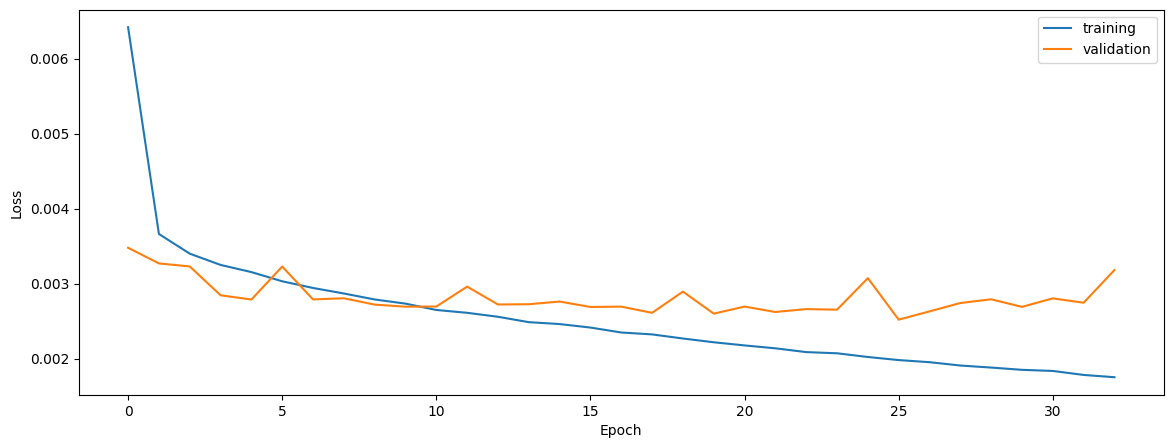

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8943763773245402
0.8416459414965112
0.8390032250442641


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8932923026337831
0.8535021715493359
0.844199621765893


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8919554216042985
0.8498901954551857
0.840449869222466


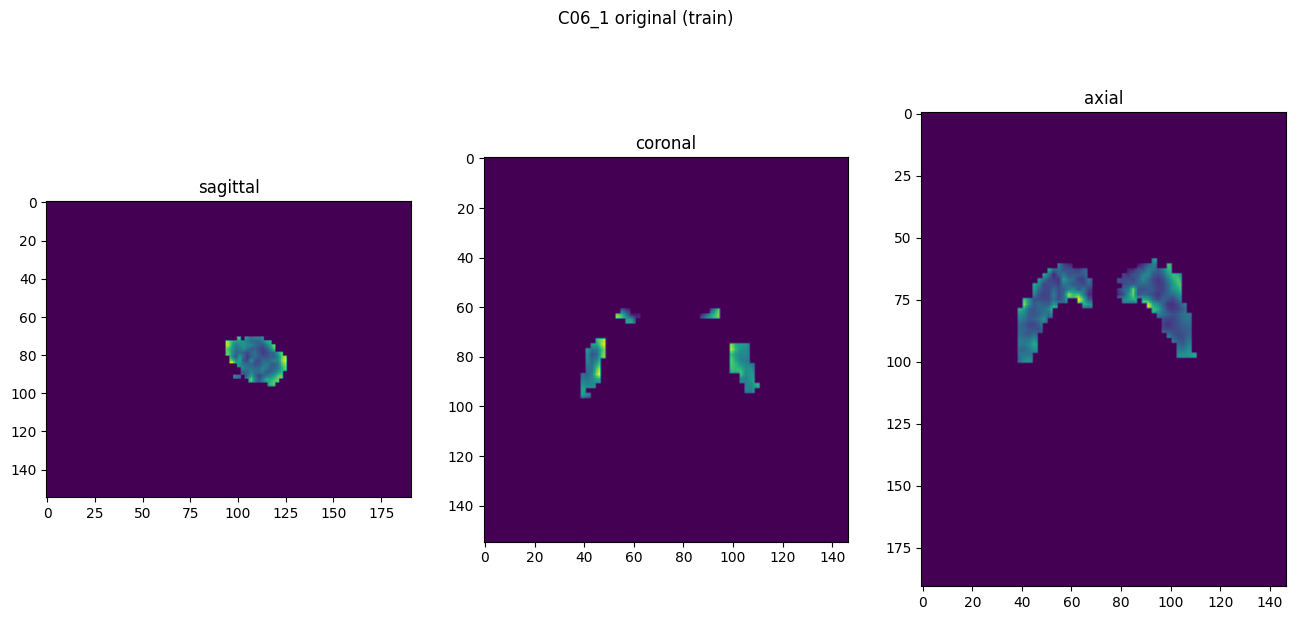

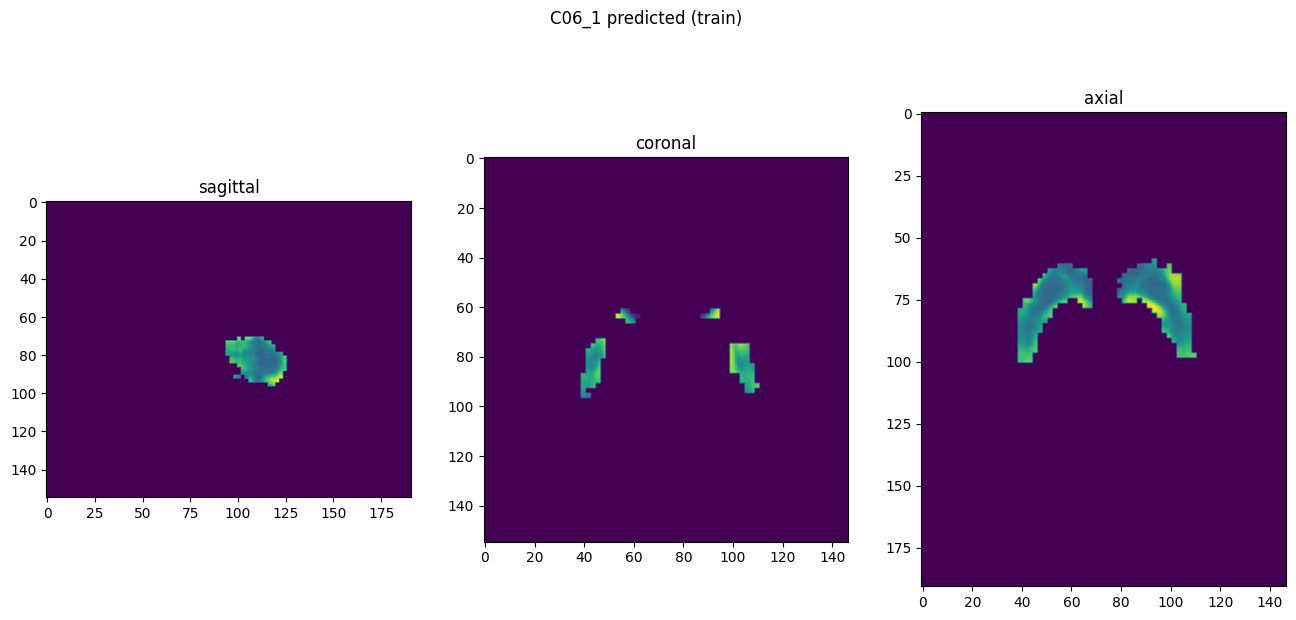

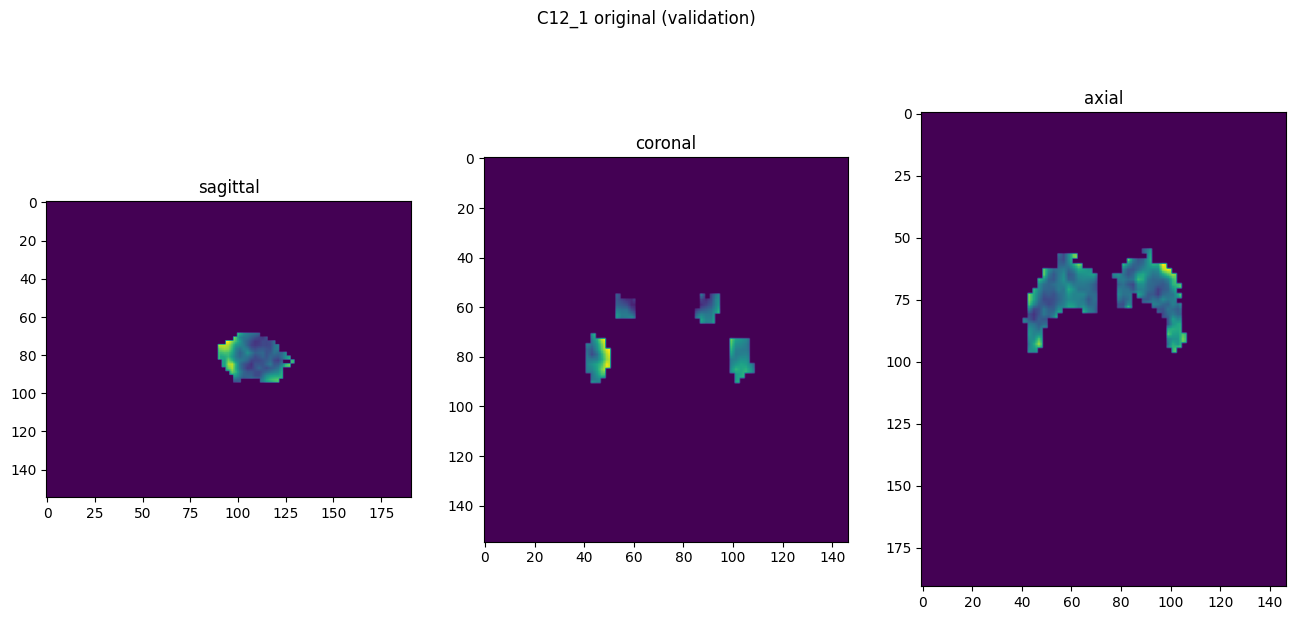

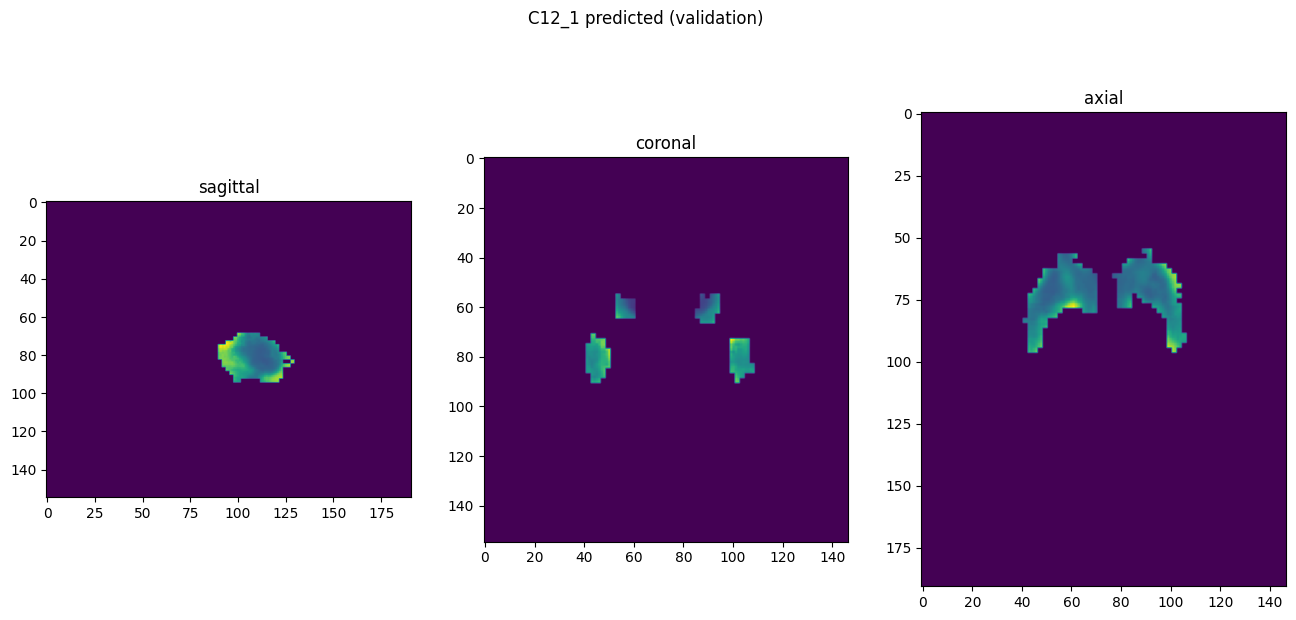

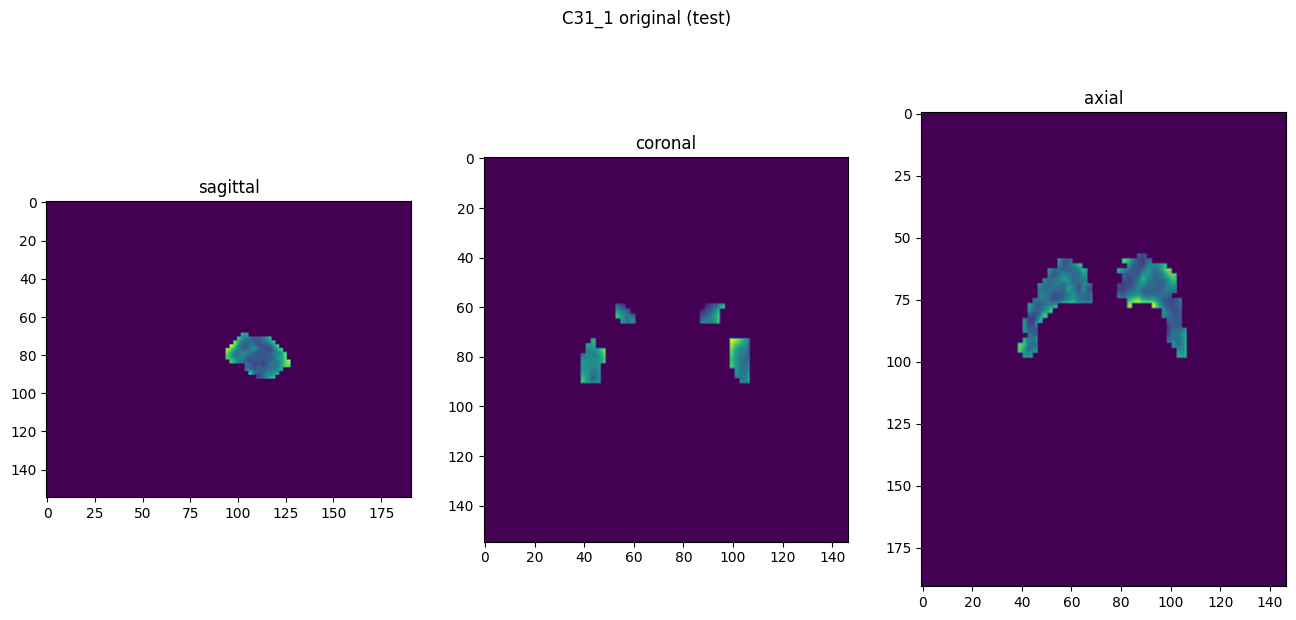

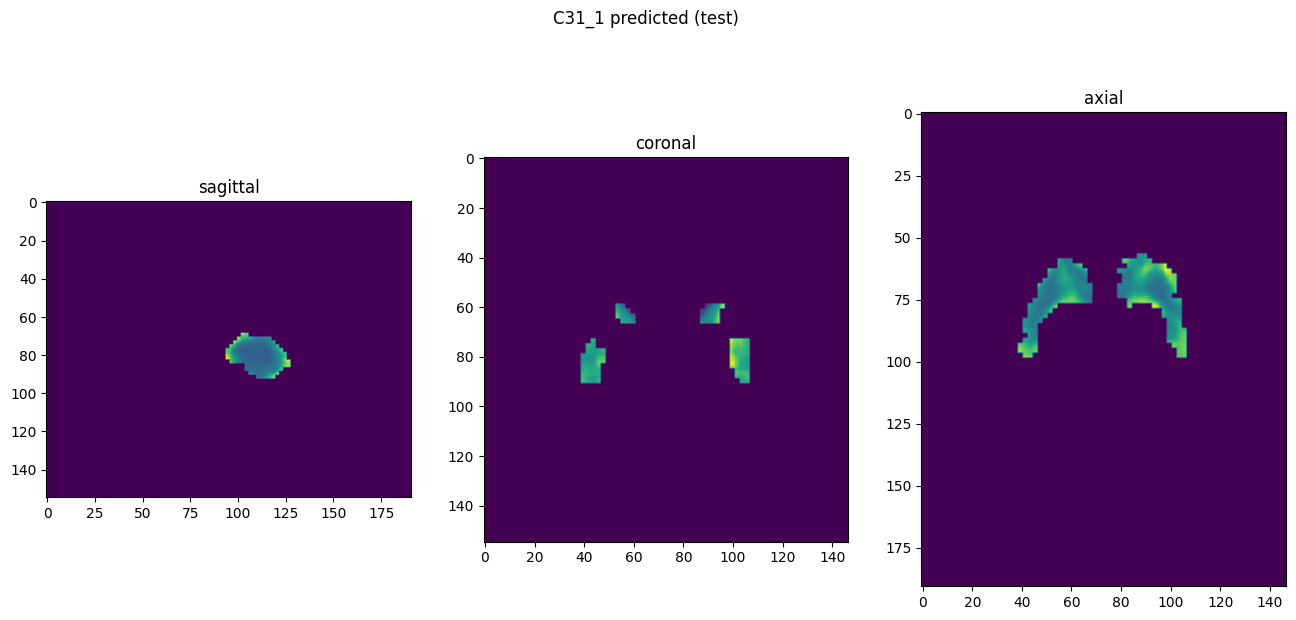

In [10]:
showResults(model, gen, threshold=None, background=False)